In [1]:
# Description of Kobe shoot dataset

*Data Description*

* action_type : action leading up to shot and shot types          
* combined_shot_type: shot types
* game_event_id: id number of the event within the game
* game_id: the serial number of the game
* lat: latitude
* loc_x : X coordinate of the playgroud	
* loc_y: Y coordinate of the playgroud
* lon : longitude
* minutes_remaining: minutes remaining of the game
* period: quarter number	
* playoffs: if in playoff games
* season : the season the game took place
* seconds_remaining: seconds remaining of the game
* shot_distance: the distance from the basket to the player
* shot_made_flag: to check whether he made a shot
* shot_type:  '2PT Field Goal' or  '3PT Field Goal'
* shot_zone_area: which area the shot came from
* shot_zone_basic: which basic area the shot came from
* shot_zone_range: which zone range the shot came from
* team_id: the id of kobe's team
* team_name: name of kobe's team
* game_date: date of the game
* matchup: which team VS which team
* opponent: opposing team

In [2]:
import pandas as pd
import numpy as np
import random as rnd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier

In [5]:
data = pd.read_csv('data.csv')

In [6]:
data.shape

(30697, 25)

## Data Analyzing -- Feature Selection and Transformation

In [7]:
data.dtypes

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
lat                   float64
loc_x                   int64
loc_y                   int64
lon                   float64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
team_id                 int64
team_name              object
game_date              object
matchup                object
opponent               object
shot_id                 int64
dtype: object

In [8]:
data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

In [9]:
data.dtypes

action_type             object
combined_shot_type    category
game_event_id         category
game_id               category
lat                    float64
loc_x                    int64
loc_y                    int64
lon                    float64
minutes_remaining        int64
period                  object
playoffs              category
season                category
seconds_remaining        int64
shot_distance            int64
shot_made_flag        category
shot_type             category
shot_zone_area          object
shot_zone_basic         object
shot_zone_range         object
team_id               category
team_name               object
game_date               object
matchup                 object
opponent                object
dtype: object

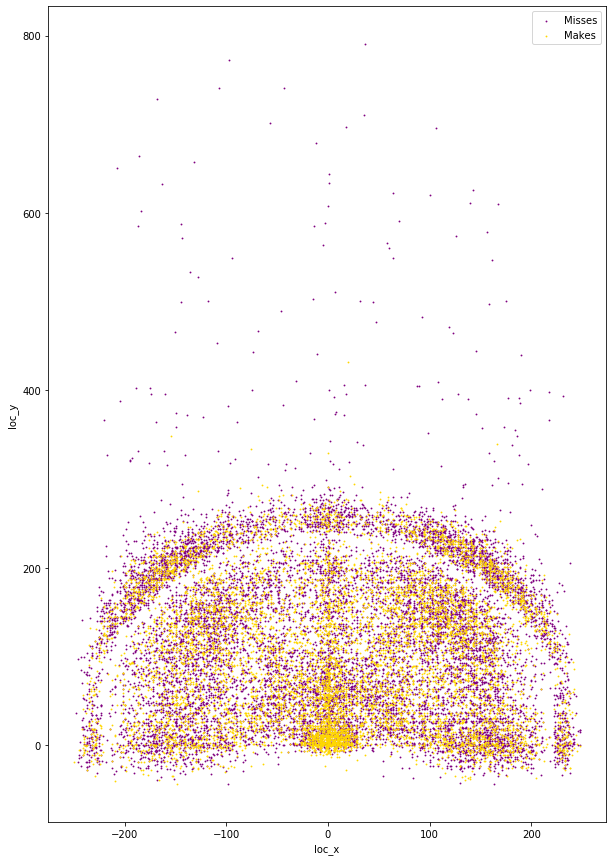

In [10]:
# scatterplot of loc_x, loc_y
plt.figure(figsize = (10, 15))
plt.scatter(data.loc_x[data['shot_made_flag'] == 0 ], data.loc_y[data['shot_made_flag'] == 0], 
    c = 'purple', s = 0.7, label = 'Misses')
plt.scatter(data.loc_x[data['shot_made_flag'] == 1 ], data.loc_y[data['shot_made_flag'] == 1], 
    c = 'gold', s = 0.7, label = 'Makes')

plt.xlabel('loc_x')
plt.ylabel('loc_y')

plt.legend()
plt.show()

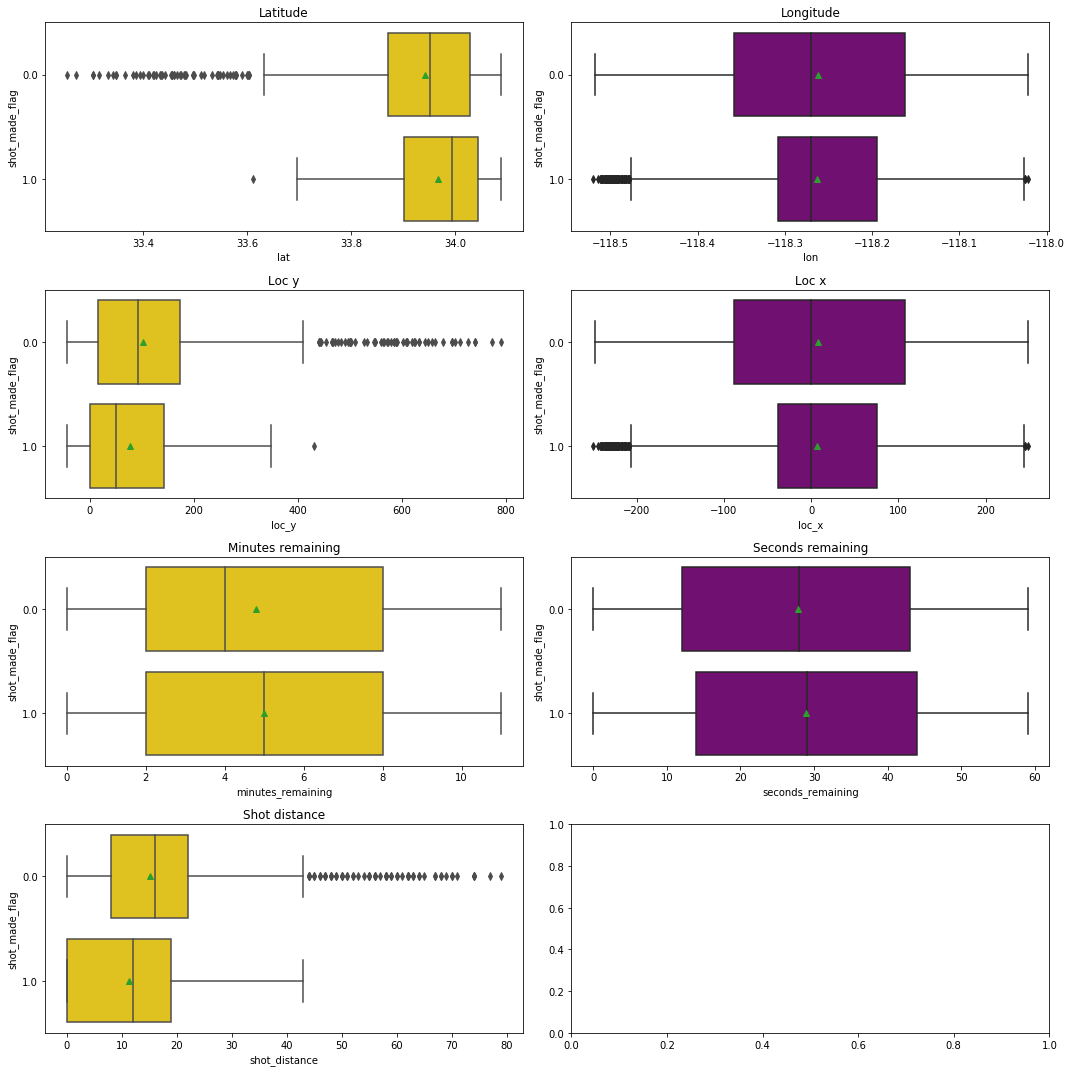

In [11]:
f, axarr = plt.subplots(4, 2, figsize=(15, 15))

sns.boxplot(x='lat', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0,0], color = 'gold')
sns.boxplot(x='lon', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0, 1], color = 'purple')
sns.boxplot(x='loc_y', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 0], color = 'gold')
sns.boxplot(x='loc_x', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 1], color = 'purple')
sns.boxplot(x='minutes_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 0], color = 'gold')
sns.boxplot(x='seconds_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 1], color = 'purple')
sns.boxplot(x='shot_distance', y='shot_made_flag', data=data, showmeans=True, ax=axarr[3, 0], color = 'gold')

axarr[0, 0].set_title('Latitude')
axarr[0, 1].set_title('Longitude')
axarr[1, 0].set_title('Loc y')
axarr[1, 1].set_title('Loc x')
axarr[2, 0].set_title('Minutes remaining')
axarr[2, 1].set_title('Seconds remaining')
axarr[3, 0].set_title('Shot distance')

plt.tight_layout()
plt.show()

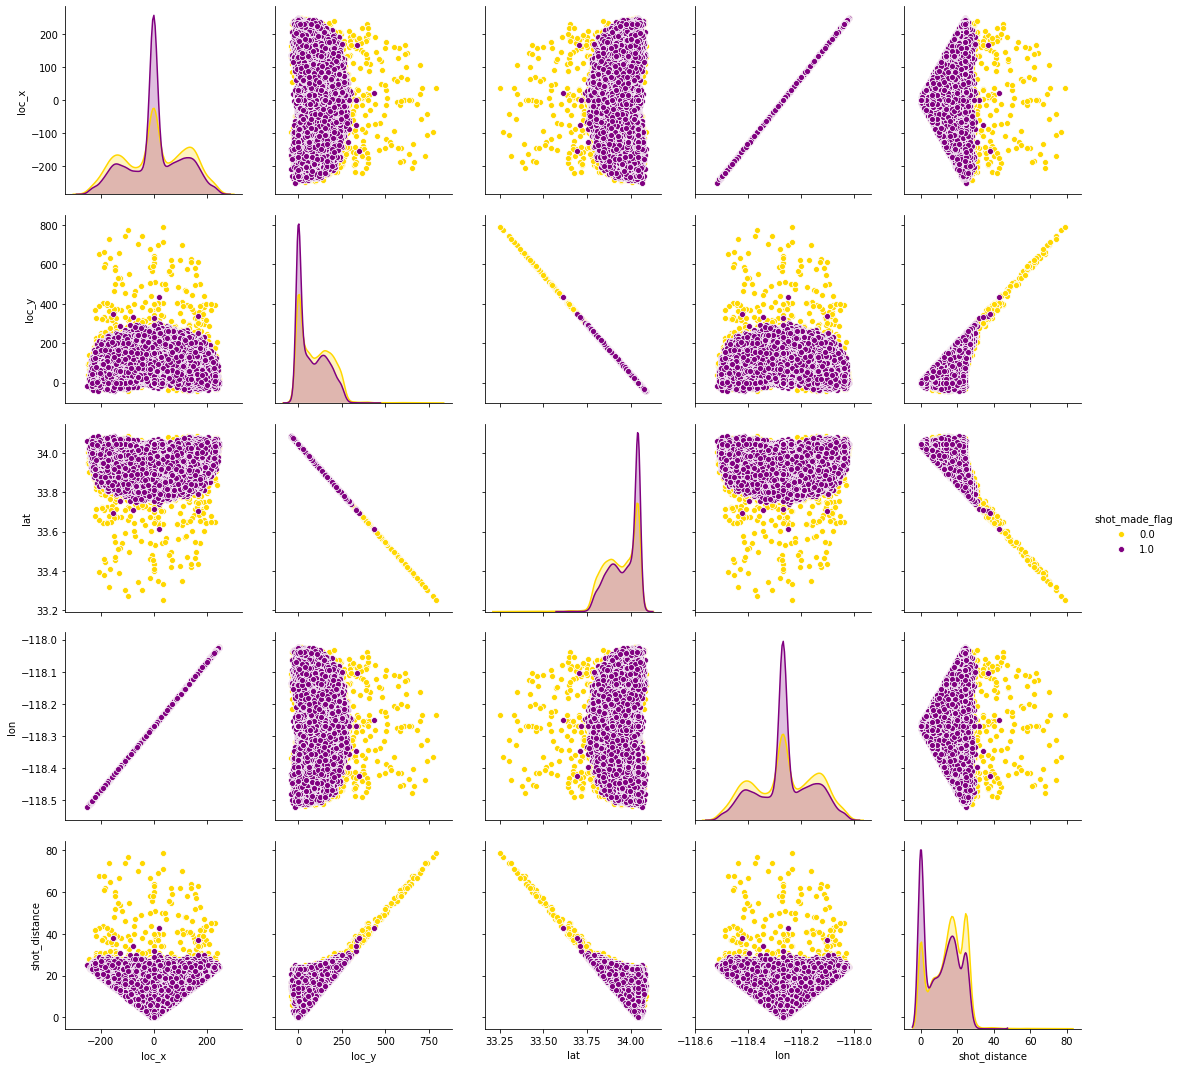

In [12]:
sns.pairplot(data, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', palette = ['gold', 'purple'], height=3)
plt.show()

In [13]:
# data cleaning
unknown_mask = data['shot_made_flag'].isnull()

# create a copy of data frame
data_cl = data.copy() 
target = data_cl['shot_made_flag'].copy()

# Remove some columns
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True)

In [14]:
# Remaining time
data_cl['seconds_from_period_end'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_5_sec_in_period'] = data_cl['seconds_from_period_end'] < 5

data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('seconds_from_period_end', axis=1, inplace=True)

# Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Game date
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year
data_cl['game_month'] = data_cl['game_date'].dt.month
data_cl.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

In [15]:
# Encode categorical variables
categorical_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y', 'playoffs']

data_cl = pd.get_dummies(data_cl[categorical_cols])

#for cc in categorial_cols:
 #   dummies = pd.get_dummies(data_cl[cc], drop_first=True)
    #dummies = dummies.add_prefix("{}#".format(cc))
  #  data_cl.drop(cc, axis=1, inplace=True)
   # data_cl = data_cl.join(dummies)

In [16]:
data_cl.dtypes

game_year                                     int64
game_month                                    int64
action_type_Alley Oop Dunk Shot               uint8
action_type_Alley Oop Layup shot              uint8
action_type_Driving Dunk Shot                 uint8
action_type_Driving Finger Roll Layup Shot    uint8
action_type_Driving Finger Roll Shot          uint8
action_type_Driving Jump shot                 uint8
action_type_Driving Layup Shot                uint8
action_type_Driving Reverse Layup Shot        uint8
action_type_Driving Slam Dunk Shot            uint8
action_type_Dunk Shot                         uint8
action_type_Fadeaway Bank shot                uint8
action_type_Fadeaway Jump Shot                uint8
action_type_Finger Roll Layup Shot            uint8
action_type_Finger Roll Shot                  uint8
action_type_Floating Jump shot                uint8
action_type_Follow Up Dunk Shot               uint8
action_type_Hook Shot                         uint8
action_type_

## Datasets & Feature Selection

In [17]:
# Separate dataset for validation
data_submit = data_cl[unknown_mask]

# Separate dataset for training
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

In [18]:
# Variance Threshold
# Find all features with more than 90% variance in values.
threshold = 0.90
vt = VarianceThreshold().fit(X)

# Find feature names
feat_var_threshold = data_cl.columns[vt.variances_ > threshold * (1-threshold)]
feat_var_threshold

Index(['game_year', 'game_month', 'action_type_Jump Shot',
       'combined_shot_type_Jump Shot', 'combined_shot_type_Layup', 'period_1',
       'period_2', 'period_3', 'period_4', 'shot_type_2PT Field Goal',
       'shot_type_3PT Field Goal', 'shot_zone_area_Center(C)',
       'shot_zone_area_Left Side Center(LC)', 'shot_zone_area_Left Side(L)',
       'shot_zone_area_Right Side Center(RC)', 'shot_zone_area_Right Side(R)',
       'shot_zone_basic_Above the Break 3',
       'shot_zone_basic_In The Paint (Non-RA)', 'shot_zone_basic_Mid-Range',
       'shot_zone_basic_Restricted Area', 'shot_zone_range_16-24 ft.',
       'shot_zone_range_24+ ft.', 'shot_zone_range_8-16 ft.',
       'shot_zone_range_Less Than 8 ft.', 'loc_x_(-10.96, 8.96]',
       'loc_y_(-10.6, 22.8]', 'loc_y_(22.8, 56.2]', 'loc_y_(123.0, 156.4]',
       'playoffs_0', 'playoffs_1'],
      dtype='object')

In [20]:
# Top 20 most important features
# According to `RandomForestClassifier`
model = RandomForestClassifier(n_estimators = 10)
model.fit(X, Y)

feature_rf = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_rf_20 = feature_rf.sort_values("importance", ascending=False).head(20).index
feat_rf_20

Index(['game_month', 'game_year', 'action_type_Jump Shot', 'period_3',
       'period_2', 'combined_shot_type_Dunk', 'period_4', 'period_1',
       'action_type_Layup Shot', 'opponent_SAS', 'opponent_PHX',
       'opponent_SAC', 'opponent_HOU', 'opponent_POR', 'loc_y_(-10.6, 22.8]',
       'opponent_MIN', 'opponent_UTA', 'opponent_DEN',
       'action_type_Running Jump Shot', 'playoffs_1'],
      dtype='object')

In [21]:
# Univariate feature selection
# Select top 20 features using chi2 test. Features must be positive before applying test.
X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, Y)
feature_chi = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })

feat_chi_20 = feature_chi.sort_values('score', ascending=False).head(20)['feature'].values
feat_chi_20

array(['combined_shot_type_Dunk', 'action_type_Jump Shot',
       'shot_zone_basic_Restricted Area', 'loc_x_(-10.96, 8.96]',
       'action_type_Driving Layup Shot',
       'shot_zone_range_Less Than 8 ft.', 'loc_y_(-10.6, 22.8]',
       'action_type_Slam Dunk Shot', 'shot_type_3PT Field Goal',
       'action_type_Driving Dunk Shot', 'shot_zone_area_Center(C)',
       'action_type_Running Jump Shot', 'shot_zone_range_24+ ft.',
       'shot_zone_basic_Above the Break 3', 'combined_shot_type_Layup',
       'combined_shot_type_Jump Shot', 'action_type_Jump Bank Shot',
       'action_type_Pullup Jump shot',
       'shot_zone_area_Left Side Center(LC)', 'action_type_Dunk Shot'],
      dtype=object)

In [22]:
# Final feature selection
# Finally features selected by all methods will be merged together
features = np.hstack([
        feat_var_threshold, 
        feat_rf_20,
        feat_chi_20,
    ])

features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

Final features set:

	-action_type_Driving Dunk Shot
	-action_type_Driving Layup Shot
	-action_type_Dunk Shot
	-action_type_Jump Bank Shot
	-action_type_Jump Shot
	-action_type_Layup Shot
	-action_type_Pullup Jump shot
	-action_type_Running Jump Shot
	-action_type_Slam Dunk Shot
	-combined_shot_type_Dunk
	-combined_shot_type_Jump Shot
	-combined_shot_type_Layup
	-game_month
	-game_year
	-loc_x_(-10.96, 8.96]
	-loc_y_(-10.6, 22.8]
	-loc_y_(123.0, 156.4]
	-loc_y_(22.8, 56.2]
	-opponent_DEN
	-opponent_HOU
	-opponent_MIN
	-opponent_PHX
	-opponent_POR
	-opponent_SAC
	-opponent_SAS
	-opponent_UTA
	-period_1
	-period_2
	-period_3
	-period_4
	-playoffs_0
	-playoffs_1
	-shot_type_2PT Field Goal
	-shot_type_3PT Field Goal
	-shot_zone_area_Center(C)
	-shot_zone_area_Left Side Center(LC)
	-shot_zone_area_Left Side(L)
	-shot_zone_area_Right Side Center(RC)
	-shot_zone_area_Right Side(R)
	-shot_zone_basic_Above the Break 3
	-shot_zone_basic_In The Paint (Non-RA)
	-shot_zone_basic_Mid-Range
	-shot_zo

In [23]:
features.shape

(47,)

In [24]:
# Prepare dataset for further analysis
data_cl = data_cl.loc[:, features]
data_submit = data_submit.loc[:, features]
X = X.loc[:, features]

print('Clean dataset shape: {}'.format(data_cl.shape))
print('Subbmitable dataset shape: {}'.format(data_submit.shape))
print('Train features shape: {}'.format(X.shape))
print('Target label shape: {}'. format(Y.shape))

Clean dataset shape: (30697, 47)
Subbmitable dataset shape: (5000, 47)
Train features shape: (25697, 47)
Target label shape: (25697,)


In [25]:
to_rename_dict = {'loc_x_(-10.96, 8.96]':'loc_x_(-10.96, 8.96)',
                  'loc_y_(-10.6, 22.8]':'loc_y_(-10.6, 22.8)',
                  'loc_y_(123.0, 156.4]':'loc_y_(123.0, 156.4)',
                  'loc_y_(22.8, 56.2]':'loc_y_(22.8, 56.2)'}

X.rename(columns = to_rename_dict, inplace = True)
X.columns

Index(['action_type_Driving Dunk Shot', 'action_type_Driving Layup Shot',
       'action_type_Dunk Shot', 'action_type_Jump Bank Shot',
       'action_type_Jump Shot', 'action_type_Layup Shot',
       'action_type_Pullup Jump shot', 'action_type_Running Jump Shot',
       'action_type_Slam Dunk Shot', 'combined_shot_type_Dunk',
       'combined_shot_type_Jump Shot', 'combined_shot_type_Layup',
       'game_month', 'game_year', 'loc_x_(-10.96, 8.96)',
       'loc_y_(-10.6, 22.8)', 'loc_y_(123.0, 156.4)', 'loc_y_(22.8, 56.2)',
       'opponent_DEN', 'opponent_HOU', 'opponent_MIN', 'opponent_PHX',
       'opponent_POR', 'opponent_SAC', 'opponent_SAS', 'opponent_UTA',
       'period_1', 'period_2', 'period_3', 'period_4', 'playoffs_0',
       'playoffs_1', 'shot_type_2PT Field Goal', 'shot_type_3PT Field Goal',
       'shot_zone_area_Center(C)', 'shot_zone_area_Left Side Center(LC)',
       'shot_zone_area_Left Side(L)', 'shot_zone_area_Right Side Center(RC)',
       'shot_zone_area_Right 

## Model, predict and solve

Consider

- Logistic Regression
- KNN or k-Nearest Neighbors
- Linear SVC
- Naive Bayes classifier
- Decision Tree
- Random Forest
- Perceptron
- Gradient Boosting

In [26]:
# Set common parameters
seed = 7
processors=2
num_folds=5
num_instances=len(X)
#scoring='neg_log_loss'

X_train,X_test,y_train,y1_test = train_test_split(X,Y,test_size = 0.33,
                                                random_state = 1)
kfold = KFold(n_splits=num_folds, random_state=seed)

In [29]:
solution_matrix_full = pd.DataFrame(index=X.index)
solution_matrix_test = pd.DataFrame(index=X_test.index)

NameError: name 'X_test' is not defined

In [28]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', LinearSVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR: (0.679) +/- (0.005)
KNN: (0.596) +/- (0.004)
CART: (0.575) +/- (0.018)
NB: (0.655) +/- (0.011)
SVC: (0.554) +/- (0.016)
RFC: (0.615) +/- (0.008)
XGB: (0.679) +/- (0.005)


In [ ]:
# Logistic Regression

In [ ]:
lr_grid = GridSearchCV(
    estimator = LogisticRegression(random_state=seed),
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 1, 10, 100, 1000]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lr_grid.fit(X, Y)

print(lr_grid.best_score_)
print(lr_grid.best_params_)

In [74]:
# KNN

In [75]:
knn_grid = GridSearchCV(
    estimator = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    param_grid = {
        'knn__n_neighbors': [5, 10, 15, 20, 25],
        'knn__algorithm': ['ball_tree'],
        'knn__leaf_size': [2, 3, 4],
        'knn__p': [1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

knn_grid.fit(X, Y)

print(knn_grid.best_score_)
print(knn_grid.best_params_)

-0.6598268888918715
{'knn__algorithm': 'ball_tree', 'knn__leaf_size': 2, 'knn__n_neighbors': 25, 'knn__p': 1}


In [64]:
# Gaussian Naive Bayes

In [65]:
gaussian_gird = GridSearchCV(
    estimator = GaussianNB(),
    param_grid = {
        
    },
    cv = kfold,
    scoring = scoring,
    n_jobs = processors)

gaussian_gird.fit(X,Y)

print(gaussian_gird.best_score_)
print(gaussian_gird.best_params_)

-3.707574848799019
{}


In [47]:
# Perceptron

In [48]:
perceptron = Perceptron(max_iter=1000,tol=0.2)
perceptron.fit(X, Y)

acc_perceptron = perceptron.score(X, Y)
print(acc_perceptron)

0.507841382262521


In [49]:
# Linear SVC

In [50]:
param_grid = [{'C':[0.001, 0.01, 0.1,1,5,100]}]
Grid = GridSearchCV(LinearSVC(max_iter = 22000),param_grid,cv=5,scoring='accuracy',
                  return_train_score = True)
Grid.fit(X,Y)
print(Grid.best_params_)

C:\Users\joong\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\joong\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\joong\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\joong\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\joong\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

KeyboardInterrupt: 

In [ ]:
# Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X, Y)

In [ ]:
# Random Forest

In [ ]:
param_grid = [{'n_estimators':[10,50,100,200],'max_depth':[5,10,15,20],
               'max_features':[3,5,6,8]}]
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid.fit(X, Y)
print(grid.best_params_)

In [ ]:
# Gradient Boosting

In [ ]:
gbm_grid = GridSearchCV(
    estimator = GradientBoostingClassifier(warm_start=True, random_state=seed),
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [2, 3, 4],
        'max_features': [10, 15, 20],
        'learning_rate': [1e-1, 1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

gbm_grid.fit(X, Y)

print(gbm_grid.best_score_)
print(gbm_grid.best_params_)

## Voting Ensemble

In [ ]:
# Create sub models
estimators = []

estimators.append(('lr', LogisticRegression(penalty='l2', C=1)))
estimators.append(('gbm', GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, max_features=10, warm_start=True, random_state=seed)))
estimators.append(('rf', RandomForestClassifier(bootstrap=True, max_depth=8, n_estimators=50, max_features=5, criterion='entropy', random_state=seed)))
estimators.append(('gaussian', GaussianNB()))
estimators.append(('DecisionTree', DecisionTreeClassifier()))

# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft', weights=[1]*5)

results = cross_val_score(ensemble, X, Y, cv=kfold, scoring=scoring,n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

In [ ]:
model = ensemble

model.fit(X, Y)
preds = model.predict_proba(data_submit)

submission = pd.DataFrame()
submission["shot_id"] = data_submit.index
submission["shot_made_flag"]= preds[:,0]

# submission.to_csv("C:\\Users\\XPS\\Downloads\\sub.csv",index=False)

### Finally, we get kaggle score which is 1.07835